In [13]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split



In [14]:
train_dir = os.path.join("fer2013", "train")
test_dir = os.path.join("fer2013", "test")


In [ ]:
#Preprocessing the data
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
#loading he data and applying the features
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform
)


In [ ]:
#splitting
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size]
)


In [18]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [19]:
print("Classes:", full_train_dataset.classes)
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train size: 22967
Val size: 5742
Test size: 7178


In [ ]:
#The CNN Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 48 → 24
        x = self.pool(F.relu(self.conv2(x)))  # 24 → 12
        x = self.pool(F.relu(self.conv3(x)))  # 12 → 6

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionCNN(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
#Training the model
epochs = 30

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.3f}, Val Acc: {val_acc:.2f}%")

Epoch [1/30], Loss: 1186.940, Val Acc: 41.62%
Epoch [2/30], Loss: 1012.830, Val Acc: 48.42%
Epoch [3/30], Loss: 929.943, Val Acc: 49.13%
Epoch [4/30], Loss: 880.442, Val Acc: 51.71%
Epoch [5/30], Loss: 844.974, Val Acc: 52.89%
Epoch [6/30], Loss: 817.259, Val Acc: 53.52%
Epoch [7/30], Loss: 791.384, Val Acc: 53.10%
Epoch [8/30], Loss: 765.972, Val Acc: 54.63%
Epoch [9/30], Loss: 749.064, Val Acc: 53.99%
Epoch [10/30], Loss: 729.801, Val Acc: 56.08%
Epoch [11/30], Loss: 710.682, Val Acc: 55.82%
Epoch [12/30], Loss: 691.995, Val Acc: 54.55%
Epoch [13/30], Loss: 678.453, Val Acc: 54.88%
Epoch [14/30], Loss: 656.806, Val Acc: 56.17%
Epoch [15/30], Loss: 640.455, Val Acc: 55.29%
Epoch [16/30], Loss: 626.501, Val Acc: 55.59%
Epoch [17/30], Loss: 615.707, Val Acc: 55.59%
Epoch [18/30], Loss: 596.880, Val Acc: 56.36%
Epoch [19/30], Loss: 585.798, Val Acc: 55.96%
Epoch [20/30], Loss: 569.722, Val Acc: 55.69%
Epoch [21/30], Loss: 556.418, Val Acc: 55.05%
Epoch [22/30], Loss: 552.121, Val Acc: 56

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#take prediction and real data from val sets
all_preds = []
all_labels = []

model.eval() # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))

# Generate a Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.47      0.47       806
     disgust       0.61      0.37      0.46        97
        fear       0.41      0.39      0.40       846
       happy       0.76      0.79      0.77      1389
     neutral       0.48      0.55      0.51      1000
         sad       0.46      0.41      0.43       984
    surprise       0.68      0.68      0.68       620

    accuracy                           0.56      5742
   macro avg       0.55      0.52      0.53      5742
weighted avg       0.56      0.56      0.56      5742



In [25]:
# Save the learned parameters
torch.save(model.state_dict(), 'emotion_cnn.pth')
print("Model saved successfully!")

Model saved successfully!


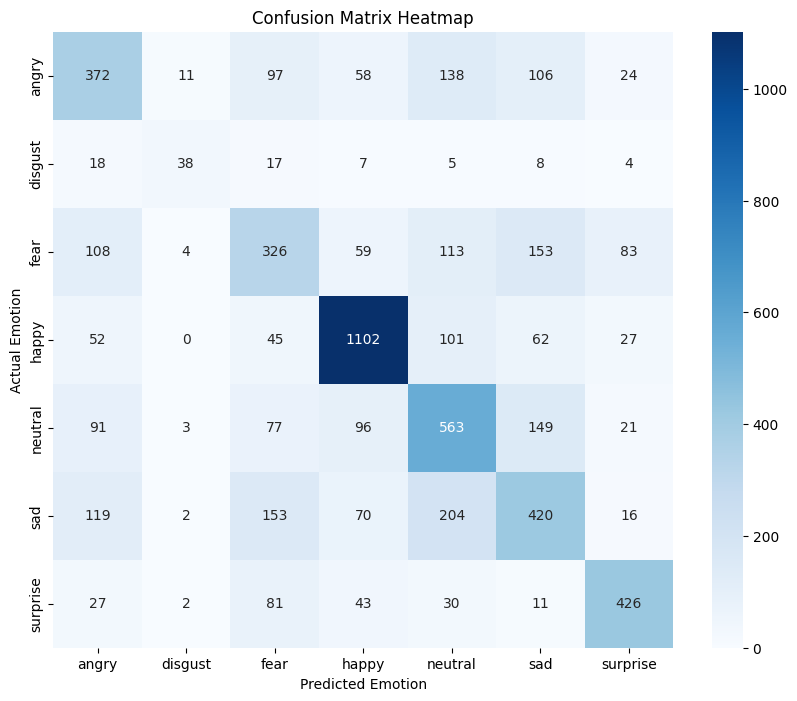

In [ ]:
# Setting the size of the plot and showing the heatmap of confusion matrix, actual vs preduction
plt.figure(figsize=(10, 8))


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_train_dataset.classes, 
            yticklabels=full_train_dataset.classes)

plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.title('Confusion Matrix Heatmap')


plt.show()